# Load packages

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import string
import os
import numpy as np

# Load data

In [3]:
inmate = pd.read_excel('./data/ReincidenciaPospenadosNal201011Junio2020Rev.xlsx', skiprows = 6)

# Severity Index

<BarContainer object of 10 artists>

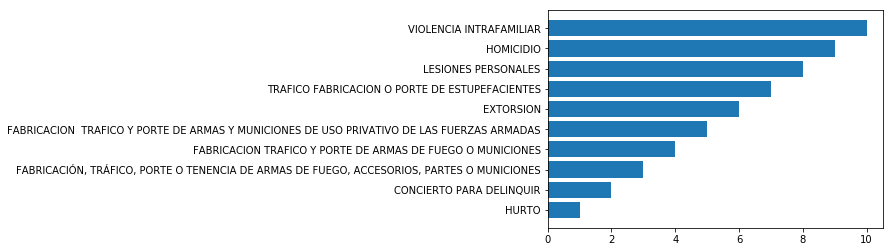

In [38]:
# Count number of observations by crime type and category
top10 = list(inmate.DELITO.value_counts().to_frame().reset_index().rename(columns = {'index':'DELITONAME'}).head(10)['DELITONAME'])
#https://leyes.co/codigo_penal.htm
#values as [min_month,max_month,decree]
dict_pena ={'HURTO': [16,108,239],
            'TRAFICO FABRICACION O PORTE DE ESTUPEFACIENTES': [128,360,376],
            'FABRICACION TRAFICO Y PORTE DE ARMAS DE FUEGO O MUNICIONES':[132,180,366],
            'CONCIERTO PARA DELINQUIR':[48,108,340],
            'HOMICIDIO':[208,450,103],
            'EXTORSION':[192,288,244],
            'FABRICACIÓN, TRÁFICO, PORTE O TENENCIA DE ARMAS DE FUEGO, ACCESORIOS, PARTES O MUNICIONES':[108,144,365],
            'VIOLENCIA INTRAFAMILIAR':[48,720,229],
            'LESIONES PERSONALES':[16,360,[111,112,113,114,115,116,117,118,119,120,121]],
            'FABRICACION  TRAFICO Y PORTE DE ARMAS Y MUNICIONES DE USO PRIVATIVO DE LAS FUERZAS ARMADAS':[132,180,366]
            }
df_severity = pd.DataFrame(dict_pena)
df_severity_t = df_severity.transpose().reset_index()
col_names=['crime','min_month','max_month','decree']
df_severity_t.columns = col_names
crime_score = {'HURTO':1,
               'TRAFICO FABRICACION O PORTE DE ESTUPEFACIENTES':7,
               'FABRICACION TRAFICO Y PORTE DE ARMAS DE FUEGO O MUNICIONES':4,
               'CONCIERTO PARA DELINQUIR':2,
               'HOMICIDIO':9, 
               'EXTORSION':6,
               'FABRICACIÓN, TRÁFICO, PORTE O TENENCIA DE ARMAS DE FUEGO, ACCESORIOS, PARTES O MUNICIONES':3,
               'VIOLENCIA INTRAFAMILIAR':10,
               'LESIONES PERSONALES':8,
               'FABRICACION  TRAFICO Y PORTE DE ARMAS Y MUNICIONES DE USO PRIVATIVO DE LAS FUERZAS ARMADAS':5
              }
inmate['crime_score'] = inmate['DELITO'].apply(lambda x: crime_score[x] if x in top10 else 0)
crime = pd.DataFrame.from_dict(crime_score, orient='index')
crime.reset_index(inplace=True)
crime.columns=['crime','score']
df= crime.sort_values('score',ascending=True)
plt.barh(y=df.crime,width=df.score)

In [41]:
#Calificado,Agravado,tentativa
CAT_cases = inmate[['TENTATIVA','AGRAVADO', 'CALIFICADO']].drop_duplicates().reset_index(drop=True)
CAT_cases['multiplier']= 'TBD'
CAT_cases.loc[5,'multiplier'] = 1  # TENTATIVA
CAT_cases.loc[0,'multiplier'] = 2    # CONSUMADO
CAT_cases.loc[4,'multiplier'] = 3 # TENTATIVA-AGRAVADO
CAT_cases.loc[7,'multiplier'] = 4  # TENTATIVA-CALIFICADO
CAT_cases.loc[6,'multiplier'] = 5 # TENTATIVA-CALIFICADO-AGRAVADO
CAT_cases.loc[3,'multiplier'] = 6    # CONSUMADO-AGRAVADO
CAT_cases.loc[2,'multiplier'] = 7    # CONSUMADO-CALIFICADO
CAT_cases.loc[1,'multiplier'] = 8    # CONSUMADO-CALIFICADO-AGRAVADO
# Feature engineering
# Generate score
inmate['CONSUMADO_b']  = inmate.TENTATIVA .apply(lambda x: 4 if x=="N" else 0)
inmate['TENTATIVA_b'] = inmate.TENTATIVA .apply(lambda x: 3 if x=="S" else 0)
inmate['CALIFICADO_b'] = inmate.CALIFICADO.apply(lambda x: 2 if x=="S" else 0)
inmate['AGRAVADO_b ']  = inmate.AGRAVADO.apply(lambda x: 1 if x=="S" else 0)
# Multiplier score
inmate['crime_multiplier'] = (inmate['CONSUMADO_b'] + inmate['TENTATIVA_b']  + inmate['CALIFICADO_b'] + inmate['AGRAVADO_b '])/7

# Severity 
inmate['severity'] = inmate.crime_score*inmate.crime_multiplier

In [64]:
temp_max = inmate[inmate.DELITO.isin(top10)].groupby(['INTERNOEN','FECHA_INGRESO','GENERO'])['severity'].max().reset_index()
temp_avg = inmate[inmate.DELITO.isin(top10)].groupby(['INTERNOEN','FECHA_INGRESO','GENERO'])['severity'].mean().reset_index()

Summary statitics severity

 General

6.857143         1
10.000000        1
1.285714         2
8.571429         2
3.000000         3
8.000000         3
7.714286         4
7.000000         4
6.000000         4
2.000000         8
9.000000        16
3.571429        33
2.142857        50
0.428571       208
5.714286       225
2.857143       291
7.142857       432
2.571429       510
4.285714       588
5.000000       664
3.857143      1196
2.857143      1304
3.428571      1458
4.571429      1586
1.714286      1588
5.714286      1682
1.428571      1889
1.142857      2742
6.428571      2945
0.714286      3879
5.142857      4032
0.571429      4865
0.857143     10070
2.285714     11414
1.000000     18561
4.000000     21948
Name: severity, dtype: int64

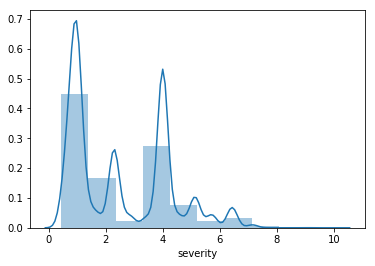

In [82]:
#import plotly.express as px
#fig = px.box(temp_max, x="EDAD", y="severity")
#fig.show()
sns.distplot(temp_max.severity, bins=10)
display(temp_max.severity.value_counts().sort_values())

,severity
count,94208.000000
mean,2.526614
std,1.719892
min,0.428571
25%,1.000000
50%,2.285714
75%,4.000000
max,10.000000


,severity
count,94208.000000
mean,2.265949
std,1.522684
min,0.428571
25%,1.000000
50%,1.642857
75%,4.000000
max,9.000000


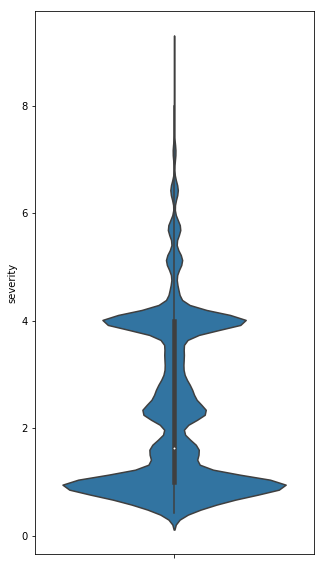

In [95]:
#sns.boxplot(y='severity', hue='GENERO',data= temp_max) #x='GENERO'
plt.figure(figsize = (5,10))
ax = sns.violinplot(y="severity", data=temp_avg)
#ax = sns.stripplot(y="severity", data=temp_avg)
display(temp_max.describe(),temp_avg.describe())

# SDHI key

In [41]:
df=pd.read_excel('./data/SHDI Colombia 4.0.xlsx')
df.tail()

,iso_code,country,year,GDLCODE,level,region,continent,shdi,healthindex,incindex,edindex,lifexp,gnic,esch,msch,pop
981,COL,Colombia,2018,COLr130,Subnat,Guainja,America,0.664,0.884,0.582,0.569,77.48,4.700667,13.20,6.06,0.042698
982,COL,Colombia,2018,COLr131,Subnat,Guaviare,America,0.749,0.883,0.710,0.671,77.38,10.972033,14.99,7.65,0.067026
983,COL,Colombia,2018,COLr132,Subnat,Vaupis,America,0.635,0.797,0.527,0.611,71.82,3.283906,14.18,6.50,0.045180
984,COL,Colombia,2018,COLr133,Subnat,Vichada,America,0.748,0.886,0.722,0.653,77.58,11.945034,13.75,8.13,0.032272
985,COL,Colombia,2018,COLt,National,Total,America,0.761,0.879,0.734,0.683,77.11,12.895595,14.60,8.33,49.648685


In [42]:
DEPTO_ESTABLECIMIENTO_key = {
     'ANTIOQUIA':'COLr101',
     'CAUCA':'COLr108',
     'CALDAS':'COLr106',
     'QUINDIO':'COLr119',
     'RISARALDA':'COLr120',
     'ATLANTICO':'COLr102',
     'HUILA':'COLr112',
     'VALLE DEL CAUCA':'COLr124',
     'NARIÑO':'COLr117',
     'ARAUCA':'COLr125',
     'BOYACA':'COLr105',
     'SUCRE':'COLr122',
     'CUNDINAMARCA':'COLr111',
     'AMAZONAS':'COLr129',
     'META':'COLr116',
     'CORDOBA':'COLr110',
     'SANTANDER':'COLr121',
     'BOGOTA D.C.':'COLr103',
     'CESAR':'COLr109',
     'BOLIVAR':'COLr104',
     'LA GUAJIRA':'COLr114',
     'CAQUETA':'COLr107',
     'NORTE DE SANTANDER':'COLr118',
     'PUTUMAYO':'COLr127',
     'TOLIMA':'COLr123',
     'SAN ANDRES Y PROVIDENCIA':'COLr128',
     'MAGDALENA':'COLr115',
     'CASANARE':'COLr126',
     'CHOCO':'COLr112'
}             
DEPTO_ESTABLECIMIENTO_key

{'ANTIOQUIA': 'COLr101',
 'CAUCA': 'COLr108',
 'CALDAS': 'COLr106',
 'QUINDIO': 'COLr119',
 'RISARALDA': 'COLr120',
 'ATLANTICO': 'COLr102',
 'HUILA': 'COLr112',
 'VALLE DEL CAUCA': 'COLr124',
 'NARIÑO': 'COLr117',
 'ARAUCA': 'COLr125',
 'BOYACA': 'COLr105',
 'SUCRE': 'COLr122',
 'CUNDINAMARCA': 'COLr111',
 'AMAZONAS': 'COLr129',
 'META': 'COLr116',
 'CORDOBA': 'COLr110',
 'SANTANDER': 'COLr121',
 'BOGOTA D.C.': 'COLr103',
 'CESAR': 'COLr109',
 'BOLIVAR': 'COLr104',
 'LA GUAJIRA': 'COLr114',
 'CAQUETA': 'COLr107',
 'NORTE DE SANTANDER': 'COLr118',
 'PUTUMAYO': 'COLr127',
 'TOLIMA': 'COLr123',
 'SAN ANDRES Y PROVIDENCIA': 'COLr128',
 'MAGDALENA': 'COLr115',
 'CASANARE': 'COLr126',
 'CHOCO': 'COLr112'}

In [43]:
inmate.DEPTO_ESTABLECIMIENTO.fillna('tbd',inplace=True)
inmate['GDLCODE']= inmate.DEPTO_ESTABLECIMIENTO.apply(lambda x: DEPTO_ESTABLECIMIENTO_key[x] if x != 'tbd' else 0)
inmate.head()

,INTERNOEN,DELITO,TITULO_DELITO,SUBTITULO_DELITO,TENTATIVA,AGRAVADO,CALIFICADO,FECHA_INGRESO,FECHA_SALIDA,FECHA_CAPTURA,...,DEPTO_ESTABLECIMIENTO,MPIO_ESTABLECIMIENTO,REGIONAL,ESTADO,crime_score,CONSUMADO_b,TENTATIVA_b,CALIFICADO_b,AGRAVADO_b,GDLCODE
0,5496C737C624136DB406CFC6744C684C070A3CD8,FABRICACION TRAFICO Y PORTE DE ARMAS DE FUEGO ...,CONTRA LA SEGURIDAD PUBLICA,DE LOS DELITOS DE PELIGRO COMUN O QUE PUEDEN O...,N,N,N,01/01/10,12/05/11,30/12/09,...,ANTIOQUIA,MEDELLIN,NOROESTE,Baja,4,4,0,0,0,COLr101
1,1097561F306939C26DB4AC60377063DA7E2B079F,TRAFICO FABRICACION O PORTE DE ESTUPEFACIENTES,CONTRA LA SALUD PUBLICA,DE LAS AFECTACIONES A LA SALUD PUBLICA,N,N,N,01/01/10,05/12/11,30/12/09,...,ANTIOQUIA,MEDELLIN,NOROESTE,Baja,7,4,0,0,0,COLr101
2,CB7033A707ADE673139F8A17CAD26AD54696C135,FABRICACION TRAFICO Y PORTE DE ARMAS DE FUEGO ...,CONTRA LA SEGURIDAD PUBLICA,DE LOS DELITOS DE PELIGRO COMUN O QUE PUEDEN O...,N,N,N,01/01/10,06/08/13,30/12/09,...,CAUCA,POPAYAN,OCCIDENTE,Baja,4,4,0,0,0,COLr108
3,CB7033A707ADE673139F8A17CAD26AD54696C135,HURTO,CONTRA EL PATRIMONIO ECONOMICO,DE LA ESTAFA,N,S,S,01/01/10,06/08/13,30/12/09,...,CAUCA,POPAYAN,OCCIDENTE,Baja,1,4,0,2,1,COLr108
4,CB7033A707ADE673139F8A17CAD26AD54696C135,UTILIZACION ILEGAL DE UNIFORMES E INSIGNIAS,CONTRA LA SEGURIDAD PUBLICA,DE LOS DELITOS DE PELIGRO COMUN O QUE PUEDEN O...,N,N,N,01/01/10,06/08/13,30/12/09,...,CAUCA,POPAYAN,OCCIDENTE,Baja,0,4,0,0,0,COLr108


In [44]:
inmate.FECHA_CAPTURA = pd.to_datetime(inmate.FECHA_CAPTURA)
inmate['year'] = inmate.FECHA_CAPTURA.dt.year
inmate.head(3)

,INTERNOEN,DELITO,TITULO_DELITO,SUBTITULO_DELITO,TENTATIVA,AGRAVADO,CALIFICADO,FECHA_INGRESO,FECHA_SALIDA,FECHA_CAPTURA,...,MPIO_ESTABLECIMIENTO,REGIONAL,ESTADO,crime_score,CONSUMADO_b,TENTATIVA_b,CALIFICADO_b,AGRAVADO_b,GDLCODE,year
0,5496C737C624136DB406CFC6744C684C070A3CD8,FABRICACION TRAFICO Y PORTE DE ARMAS DE FUEGO ...,CONTRA LA SEGURIDAD PUBLICA,DE LOS DELITOS DE PELIGRO COMUN O QUE PUEDEN O...,N,N,N,01/01/10,12/05/11,2009-12-30,...,MEDELLIN,NOROESTE,Baja,4,4,0,0,0,COLr101,2009
1,1097561F306939C26DB4AC60377063DA7E2B079F,TRAFICO FABRICACION O PORTE DE ESTUPEFACIENTES,CONTRA LA SALUD PUBLICA,DE LAS AFECTACIONES A LA SALUD PUBLICA,N,N,N,01/01/10,05/12/11,2009-12-30,...,MEDELLIN,NOROESTE,Baja,7,4,0,0,0,COLr101,2009
2,CB7033A707ADE673139F8A17CAD26AD54696C135,FABRICACION TRAFICO Y PORTE DE ARMAS DE FUEGO ...,CONTRA LA SEGURIDAD PUBLICA,DE LOS DELITOS DE PELIGRO COMUN O QUE PUEDEN O...,N,N,N,01/01/10,06/08/13,2009-12-30,...,POPAYAN,OCCIDENTE,Baja,4,4,0,0,0,COLr108,2009


In [46]:
df_merge = pd.merge(inmate,df,how='left',on= ['year','GDLCODE'])
df_merge.head()

,INTERNOEN,DELITO,TITULO_DELITO,SUBTITULO_DELITO,TENTATIVA,AGRAVADO,CALIFICADO,FECHA_INGRESO,FECHA_SALIDA,FECHA_CAPTURA,...,continent,shdi,healthindex,incindex,edindex,lifexp,gnic,esch,msch,pop
0,5496C737C624136DB406CFC6744C684C070A3CD8,FABRICACION TRAFICO Y PORTE DE ARMAS DE FUEGO ...,CONTRA LA SEGURIDAD PUBLICA,DE LOS DELITOS DE PELIGRO COMUN O QUE PUEDEN O...,N,N,N,01/01/10,12/05/11,2009-12-30,...,America,0.731,0.861,0.713,0.636,75.96,11.248776,14.27,7.19,6.063101
1,1097561F306939C26DB4AC60377063DA7E2B079F,TRAFICO FABRICACION O PORTE DE ESTUPEFACIENTES,CONTRA LA SALUD PUBLICA,DE LAS AFECTACIONES A LA SALUD PUBLICA,N,N,N,01/01/10,05/12/11,2009-12-30,...,America,0.731,0.861,0.713,0.636,75.96,11.248776,14.27,7.19,6.063101
2,CB7033A707ADE673139F8A17CAD26AD54696C135,FABRICACION TRAFICO Y PORTE DE ARMAS DE FUEGO ...,CONTRA LA SEGURIDAD PUBLICA,DE LOS DELITOS DE PELIGRO COMUN O QUE PUEDEN O...,N,N,N,01/01/10,06/08/13,2009-12-30,...,America,0.686,0.835,0.658,0.587,74.29,7.814084,13.79,6.12,1.249653
3,CB7033A707ADE673139F8A17CAD26AD54696C135,HURTO,CONTRA EL PATRIMONIO ECONOMICO,DE LA ESTAFA,N,S,S,01/01/10,06/08/13,2009-12-30,...,America,0.686,0.835,0.658,0.587,74.29,7.814084,13.79,6.12,1.249653
4,CB7033A707ADE673139F8A17CAD26AD54696C135,UTILIZACION ILEGAL DE UNIFORMES E INSIGNIAS,CONTRA LA SEGURIDAD PUBLICA,DE LOS DELITOS DE PELIGRO COMUN O QUE PUEDEN O...,N,N,N,01/01/10,06/08/13,2009-12-30,...,America,0.686,0.835,0.658,0.587,74.29,7.814084,13.79,6.12,1.249653


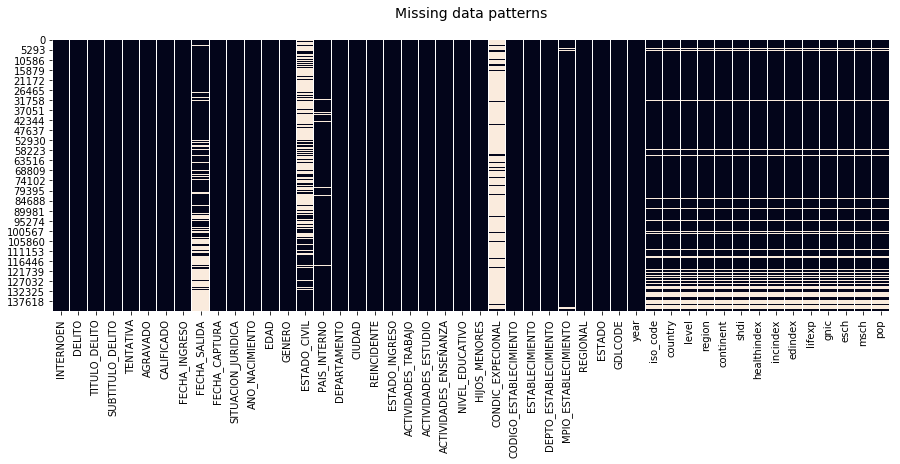

In [45]:
plt.figure(figsize = (15,5))
sns.heatmap(df_merge.isnull(), cbar = False)
plt.title('Missing data patterns\n', fontsize = 14)
plt.show()